<a href="https://colab.research.google.com/github/sayakpaul/SimCLR-in-TensorFlow-2/blob/master/Linear_Evaluation_Imagenet_Subset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Initial setup

In [1]:
import tensorflow as tf
print(tf.__version__)

2.2.0-rc4


In [2]:
!nvidia-smi

Sat May  9 04:57:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# Install wandb for experiment tracking
!pip install --upgrade https://github.com/wandb/client/archive/feature/code-save.zip

In [0]:
import wandb
wandb.login()

### Restoring model weights from GCS Bucket

In [0]:
from google.colab import auth
auth.authenticate_user()

PROJECT_ID = "fast-ai-exploration" 
!gcloud config set project $PROJECT_ID

In [0]:
!gsutil cp gs://resnet_simclr_imagenet/20200508-134915resnet_simclr.h5 .

Copying gs://resnet_simclr_imagenet/20200508-134915resnet_simclr.h5...
| [1 files][ 92.4 MiB/ 92.4 MiB]                                                
Operation completed over 1 objects/92.4 MiB.                                     


### Restoring model weights from `wandb` run page

In [0]:
simclr_weights = wandb.restore("20200509-042927resnet_simclr.h5", run_path="sayakpaul/simclr/simclr-learning")

In [0]:
# Other imports
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt
from imutils import paths
from tqdm import tqdm
import tensorflow as tf
import seaborn as sns
import numpy as np
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

## Dataset gathering and preparation

In [0]:
# Gather dataset
!git clone https://github.com/thunderInfy/imagenet-5-categories

In [6]:
# Train and test image paths
train_images = list(paths.list_images("imagenet-5-categories/train"))
test_images = list(paths.list_images("imagenet-5-categories/test"))
print(len(train_images), len(test_images))

1250 250


In [7]:
# 10% of the dataset
train_images_10 = np.random.choice(train_images, len(train_images)//10)
len(train_images_10)

125

In [0]:
def prepare_images(image_paths):
    images = []
    labels = []

    for image in tqdm(image_paths):
        image_pixels = plt.imread(image)
        image_pixels = cv2.resize(image_pixels, (224, 224))
        image_pixels = image_pixels/255.

        label = image.split("/")[2].split("_")[0]

        images.append(image_pixels)
        labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    print(images.shape, labels.shape)

    return images, labels

In [9]:
X_train, y_train = prepare_images(train_images_10)
X_test, y_test = prepare_images(test_images)

  9%|▉         | 23/250 [00:00<00:01, 225.78it/s]

(125, 224, 224, 3) (125,)


100%|██████████| 250/250 [00:01<00:00, 210.46it/s]


(250, 224, 224, 3) (250,)


In [0]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

## Utilities

In [0]:
# Architecture utils
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=(224, 224, 3))
    base_model.trainabe = True
    inputs = Input((224, 224, 3))
    h = base_model(inputs, training=True)
    h = GlobalAveragePooling2D()(h)

    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [12]:
resnet_simclr = get_resnet_simclr(256, 128, 50)
resnet_simclr.load_weights(simclr_weights.name)
resnet_simclr.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               524544    
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0     

In [0]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [0]:
def get_linear_model(features):
    linear_model = Sequential([Dense(5, input_shape=(features, ), activation="softmax")])
    return linear_model

## Evaluation

In [20]:
# Encoder model with non-linear projections
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 128) (250, 128)


In [0]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
2/2 [==============================] - 0s 97ms/step - loss: 3.4573 - accuracy: 0.2080 - val_loss: 3.1738 - val_accuracy: 0.2000
Epoch 2/35
2/2 [==============================] - 0s 37ms/step - loss: 3.2707 - accuracy: 0.2240 - val_loss: 3.0071 - val_accuracy: 0.1920
Epoch 3/35
2/2 [==============================] - 0s 35ms/step - loss: 3.0847 - accuracy: 0.2480 - val_loss: 2.8568 - val_accuracy: 0.1960
Epoch 4/35
2/2 [==============================] - 0s 29ms/step - loss: 2.9313 - accuracy: 0.2480 - val_loss: 2.7223 - val_accuracy: 0.1960
Epoch 5/35
2/2 [==============================] - 0s 30ms/step - loss: 2.7865 - accuracy: 0.2480 - val_loss: 2.6039 - val_accuracy: 0.2160
Epoch 6/35
2/2 [==============================] - 0s 30ms/step - loss: 2.6682 - accuracy: 0.2240 - val_loss: 2.5021 - val_accuracy: 0.2320
Epoch 7/35
2/2 [==============================] - 0s 29ms/step - loss: 2.5607 - accuracy: 0.2320 - val_loss: 2.4152 - val_accuracy: 0.2440
Epoch 8/35
2/2 [===========

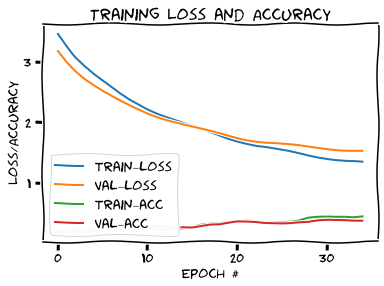

In [22]:
# Linear model
wandb.init(project="simclr", id="linear-eval-relu-last")

linear_model = get_linear_model(128)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [23]:
# Encoder model with less non-linearity
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 256) (250, 256)


Epoch 1/35
2/2 [==============================] - 0s 59ms/step - loss: 4.3073 - accuracy: 0.2720 - val_loss: 3.4971 - val_accuracy: 0.2520
Epoch 2/35
2/2 [==============================] - 0s 29ms/step - loss: 3.7693 - accuracy: 0.2640 - val_loss: 3.0359 - val_accuracy: 0.3000
Epoch 3/35
2/2 [==============================] - 0s 29ms/step - loss: 3.3674 - accuracy: 0.2800 - val_loss: 2.7083 - val_accuracy: 0.2920
Epoch 4/35
2/2 [==============================] - 0s 34ms/step - loss: 3.0538 - accuracy: 0.3040 - val_loss: 2.4554 - val_accuracy: 0.3080
Epoch 5/35
2/2 [==============================] - 0s 30ms/step - loss: 2.7831 - accuracy: 0.2880 - val_loss: 2.2482 - val_accuracy: 0.3000
Epoch 6/35
2/2 [==============================] - 0s 31ms/step - loss: 2.5590 - accuracy: 0.2960 - val_loss: 2.0802 - val_accuracy: 0.3160
Epoch 7/35
2/2 [==============================] - 0s 35ms/step - loss: 2.3567 - accuracy: 0.3040 - val_loss: 1.9590 - val_accuracy: 0.3320
Epoch 8/35
2/2 [===========

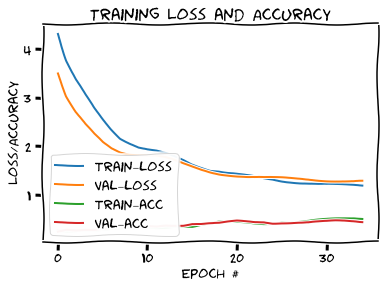

In [24]:
wandb.init(project="simclr", id="linear-eval-relu-second-last")

linear_model = get_linear_model(256)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

In [16]:
# Encoder model with no projection
projection = Model(resnet_simclr.input, resnet_simclr.layers[-6].output)

# Extract train and test features
train_features = projection.predict(X_train)
test_features = projection.predict(X_test)

print(train_features.shape, test_features.shape)

(125, 2048) (250, 2048)


Epoch 1/35
2/2 [==============================] - 0s 62ms/step - loss: 2.7671 - accuracy: 0.2080 - val_loss: 2.7753 - val_accuracy: 0.0880
Epoch 2/35
2/2 [==============================] - 0s 29ms/step - loss: 2.5326 - accuracy: 0.0880 - val_loss: 2.0067 - val_accuracy: 0.1440
Epoch 3/35
2/2 [==============================] - 0s 33ms/step - loss: 2.0193 - accuracy: 0.1760 - val_loss: 2.0003 - val_accuracy: 0.2200
Epoch 4/35
2/2 [==============================] - 0s 30ms/step - loss: 1.7629 - accuracy: 0.2880 - val_loss: 1.7460 - val_accuracy: 0.3240
Epoch 5/35
2/2 [==============================] - 0s 34ms/step - loss: 1.5828 - accuracy: 0.3360 - val_loss: 1.4421 - val_accuracy: 0.4360
Epoch 6/35
2/2 [==============================] - 0s 32ms/step - loss: 1.3496 - accuracy: 0.4400 - val_loss: 1.4247 - val_accuracy: 0.4120
Epoch 7/35
2/2 [==============================] - 0s 159ms/step - loss: 1.3587 - accuracy: 0.4640 - val_loss: 1.3853 - val_accuracy: 0.4400
Epoch 8/35
2/2 [==========

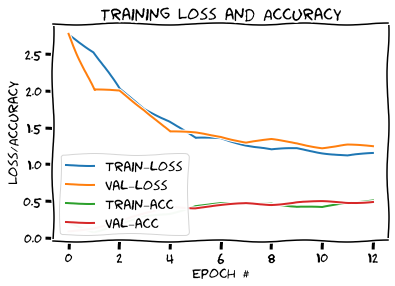

In [26]:
wandb.init(project="simclr", id="linear-eval-no-projections")

linear_model = get_linear_model(2048)
linear_model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer="adam")
history = linear_model.fit(train_features, y_train_enc,
                 validation_data=(test_features, y_test_enc),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es, WandbCallback()])
plot_training(history)

## Visualization of the representations

In [13]:
wandb.init(project="simclr", id="visualization")

W&B Run: https://app.wandb.ai/sayakpaul/simclr/runs/visualization

In [0]:
# Visualization of the representations
def plot_vecs_n_labels(v, labels):
    fig = plt.figure(figsize = (10, 10))
    sns.set_style("darkgrid")
    sns.scatterplot(v[:,0], v[:,1], hue=labels, legend='full', palette=sns.color_palette("bright", 5))
    plt.show()

    return fig

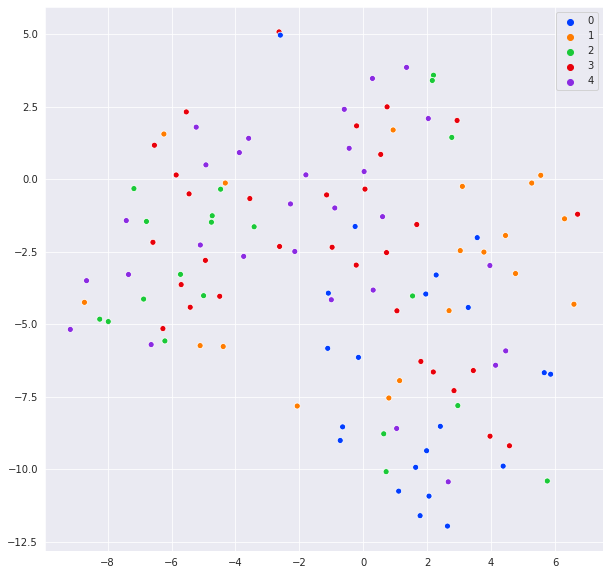

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [21]:
# Representations with no nonlinear projections
tsne = TSNE()
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"no_no_linear_projection": fig})

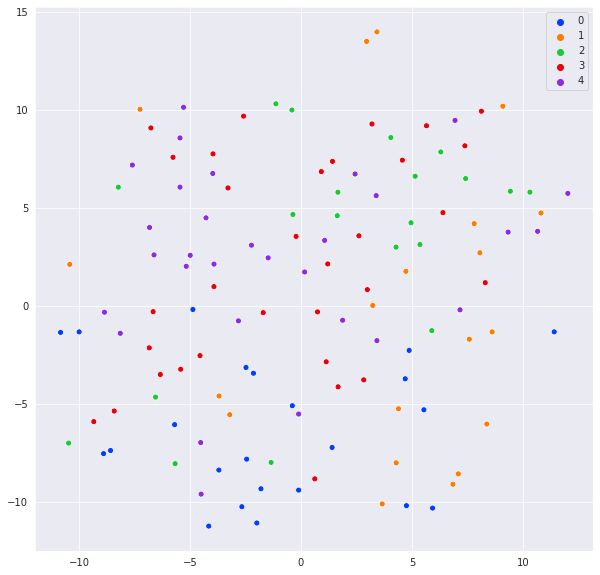

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [22]:
# Representations with second last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-4].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"second_last_relu": fig})

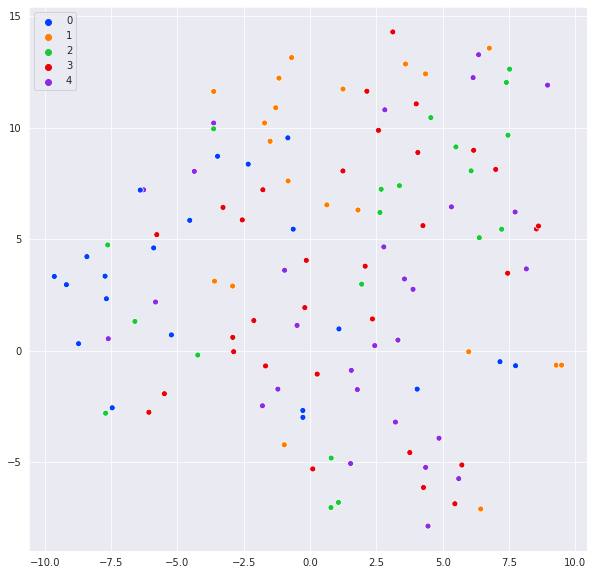

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:474: UserWarning:

Dang! That path collection is out of this world. I totally don't know what to do with it yet! Plotly can only import path collections linked to 'data' coordinates

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/renderer.py:512: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



In [23]:
# Representations with the last ReLU
tsne = TSNE()
projection = Model(resnet_simclr.input, resnet_simclr.layers[-2].output)
train_features = projection.predict(X_train)
low_vectors = tsne.fit_transform(train_features)
fig = plot_vecs_n_labels(low_vectors, y_train_enc)
wandb.log({"last_relu": fig})